### Load libraries

In [1]:
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
import scipy as sc
import scipy.stats as ss
from scipy import optimize
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D

### Load data

In [2]:
file = 'data.xlsx'
xl = pd.ExcelFile(file)
# Load a sheet into a DataFrame by name: df1
df1 = xl.parse('calibración', index_col=None, header=None)

### Load sets of parameters

In [3]:
# Strike Prices (K)
strike = df1[4][18:69]
strike = np.asarray(strike)
strike = np.array(strike, dtype=np.float64)

# Forwards (f) array
fwd = np.zeros([18])
for i in range(5,23):
    fwd[i-5] = df1[i][15]
    
# Time to Exercise (tau), in years
t0 = 43566 # April 11, 2019 is time zero for us
Tex = np.zeros([18])
for i in range(5,23):
    Tex[i-5] = (df1[i][17] - t0)/365

# Observed Implied volatility array
s = (len(strike),len(Tex))
sigma_iv = np.zeros(s)
for i in range(5,23):
    for j in range(18,69):
        sigma_iv[j-18][i-5] = df1[i][j]

sigma_iv=np.array(sigma_iv,dtype=np.float64)

# Rho array
rhos = np.zeros([18])
for i in range(5,23):
    rhos[i-5] = df1[i][2]
# Alpha array
alphas = np.zeros([18])
for i in range(5,23):
    alphas[i-5] = df1[i][3]
# Sigma_0 array
sigmas0 = np.zeros([18])
for i in range(5,23):
    sigmas0[i-5] = df1[i][4]

# 1. Calibration of the SABR Model

SABR Model:

$$df_{t}=\sigma_{t}f_{t}^\beta dW_{1t}$$

$$d\sigma_{t}=\alpha\sigma_{t}dW_{2t}$$

$$dW_{1t}dW_{2t}=\rho dt$$

We use Hagan's formula for implied volatility and simplify it by assuming $\beta=1$:

$$\sigma(K)=\sigma_{0}\frac{z}{x(z)}\bigg[1+\frac{1}{8}\tau\bigg(2\alpha\rho\sigma_{0}+\alpha^2\bigg(\frac{2}{3}-\rho^2\bigg)\bigg)\bigg]$$

$$x(z)=\log\bigg[\frac{\sqrt{1-2\rho z+z^2}+(z-\rho)}{1-\rho}\bigg]$$

$$z=\frac{\alpha}{\sigma_0}\log\Big(\frac{f}{K}\Big)$$

We are going to fit a Least Squares optimization to this system of equations in order to get $\alpha, \rho, \sigma_{0}$

In [4]:
# Define function to optimize by Least Squares assuming beta=1

def sabrcalib(K,alpha,rho,sigma0):
         
    z=(alpha*np.log(f/K))/sigma0
    x=np.log((np.sqrt(1-2*rho*z+z**2)+z-rho)/(1-rho))
    sigma=sigma0*(z/x)*(1+0.125*tau*(2*alpha*rho*sigma0+alpha**2*((2/3)-rho**2)))
    
    return sigma

In [5]:
# Calibrate the above function for each maturity using Non-Linear Least Squares:
s = (3,len(Tex))
param = np.zeros(s)
for i in range(0,len(Tex)):
    f = fwd[i]
    tau = Tex[i]
    x0 = np.array([0.7,-0.5,0.15])
    popt, pcov = sc.optimize.curve_fit(sabrcalib,strike,sigma_iv[:,i],x0)
    param[:,i]= np.transpose(popt)

In [6]:
# Creating the vectors for each parameter
alpha_c = param[0,:]
rho_c = param[1,:]
sigma0_c = param[2,:]

In [7]:
param[:,8]

array([ 0.59901143, -0.5828267 ,  0.15163048])

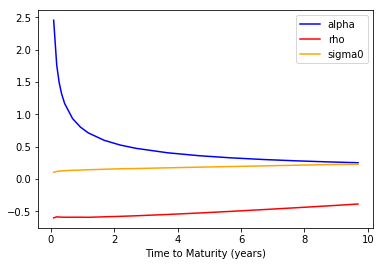

In [8]:
plt.plot(Tex,alpha_c, color='blue',label='alpha')
plt.plot(Tex,rho_c,color='red',label='rho')
plt.plot(Tex,sigma0_c, color='orange',label='sigma0')
plt.xlabel("Time to Maturity (years)")
plt.show
plt.legend()
plt.savefig('param_calib')

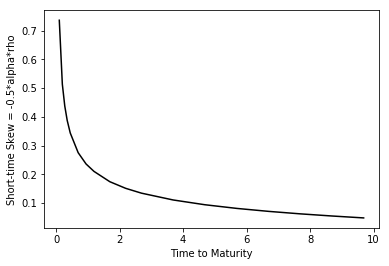

In [9]:
stskew=-0.5*rho_c*alpha_c
T1=np.reciprocal(Tex)
plt.plot(Tex,stskew, color='black')
plt.ylabel("Short-time Skew = -0.5*alpha*rho")
plt.xlabel("Time to Maturity")
plt.show
plt.savefig('stskew')

# 2. Implied volatility estimation using Hagan Formula

In [10]:
def hagan(K,f,tau,alpha,beta,rho,sigma0):
    N=1 + ( (((1-beta)**2)/24)*((sigma0**2)/(f*K)**(1-beta)) +
      0.25*(rho*beta*alpha*sigma0)/(f*K)**((1-beta)/2) +
      (2-3*rho**2)*(alpha**2)/24 )*tau
    D= (f*K)**((1-beta)/2)*(1 + ((1-beta)**2)*(np.log(f/K)**2)/24 +
                       ((1-beta)**4)*(np.log(f/K)**4)/1920)
    z=(alpha/sigma0)*(f*K)**((1-beta)/2)*np.log(f/K)
    x_z=np.log((np.sqrt(1-2*rho*z+z**2)+z-rho)/(1-rho))
    IV=sigma0*(N/D)*(z/x_z)    
    return IV

### Calibrating for a single set of parameters 


In [11]:
#Set of parameters (9th maturity)
alpha=alpha_c[8]
sigma0=sigma0_c[8]
rho=rho_c[8]
   #f=fwd[8]
beta=1
t1 = time()

s=(len(strike),len(Tex))
IV_hagan1 = np.zeros(s)
for j in range(0,len(Tex)):
    for i in range(0,len(strike)):
        IV_hagan1[i][j] = hagan(strike[i],fwd[j],Tex[j],alpha,beta,rho,sigma0)

print('Time to get vol. surface: {} seconds'.format(round((time() - t1), 5)))

Time to get vol. surface: 0.05696 seconds


### Calibrating for a given set of parameters and for each maturity

In [12]:
# Note that parameters change for each maturity
beta=1

IV_hagan = np.zeros(s)
t2 = time()
for j in range(0,len(Tex)):
    for i in range(0,len(strike)):
        IV_hagan[i][j] = hagan(strike[i],fwd[j],Tex[j],alpha_c[j],beta,rho_c[j],sigma0_c[j])
    
print('Time to get vol. surface: {} seconds'.format(round((time() - t2), 5)))

Time to get vol. surface: 0.07296 seconds


### Drawing Volatility Smiles and Volatility Surfaces

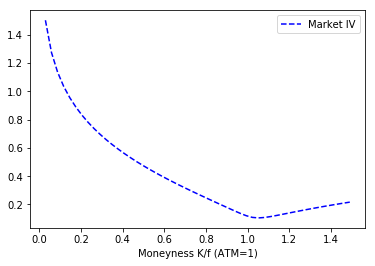

In [13]:
# Using a single set of parameters
## Drawing Smile for a single maturity
f0=fwd[1]
atm=strike/f0

plt.plot(atm,sigma_iv[:,1],'g--',color='blue',label='Market IV')
plt.xlabel('Moneyness K/f (ATM=1)')
plt.show
plt.legend()
plt.savefig('smile_mkt')

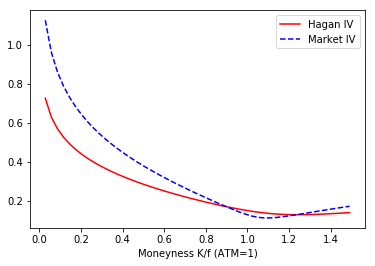

In [18]:
# Using a single set of parameters
## Drawing Smile for a single maturity

plt.plot(atm,IV_hagan1[:,4],color= 'red',label='Hagan IV')
plt.plot(atm,sigma_iv[:,4],'g--',color='blue',label='Market IV')
plt.xlabel('Moneyness K/f (ATM=1)')
plt.show
plt.legend()
#plt.savefig('smile_hagan1')

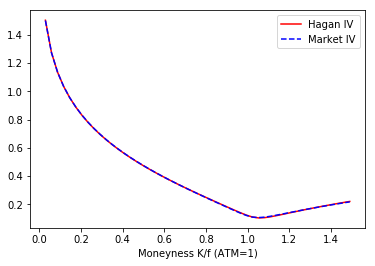

In [15]:
# Using a set of parameters for each maturity
## Drawing Smile for a single maturity
plt.plot(atm,IV_hagan[:,1],color= 'red', label='Hagan IV')
plt.plot(atm,sigma_iv[:,1],'g--',color='blue',label='Market IV')
plt.xlabel('Moneyness K/f (ATM=1)')
plt.show
plt.legend()
plt.savefig('smile_hagan')

#### Volatility Surface

In [16]:
def impliedvolatility_fixed(T,K):
    return IV_hagan1[T][K]
def observed_volatilility(T,K):
    return sigma_iv[T][K]

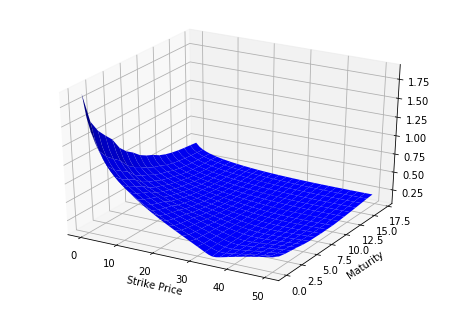

In [17]:
# Using a single set of parameters
T= np.arange (0, 51, 1) 
K= np.arange (0, 18, 1)

impliedvol=np.vectorize(impliedvolatility_fixed)
observol=np.vectorize(observed_volatilility)
X, Y = np.meshgrid(T,K)
iv = impliedvol(X,Y)
ov= observol(X,Y)

fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(X,Y, ov,color='blue')
#ax.view_init(60,45)
plt.xlabel('Strike Price')
plt.ylabel('Maturity')
plt.show()

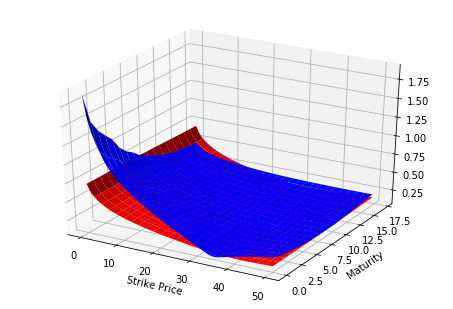

In [18]:
# Using a single set of parameters
T= np.arange (0, 51, 1) 
K= np.arange (0, 18, 1)

impliedvol=np.vectorize(impliedvolatility_fixed)
observol=np.vectorize(observed_volatilility)
X, Y = np.meshgrid(T,K)
iv = impliedvol(X,Y)
ov= observol(X,Y)

fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(X,Y, ov,color='blue')
ax.plot_surface(X,Y, iv, color='red')
#ax.view_init(60,45)
plt.xlabel('Strike Price')
plt.ylabel('Maturity')
plt.show()

In [19]:
def impliedvolatility_2(T,K):
    return IV_hagan[T][K]
def observed_volatilility(T,K):
    return sigma_iv[T][K]

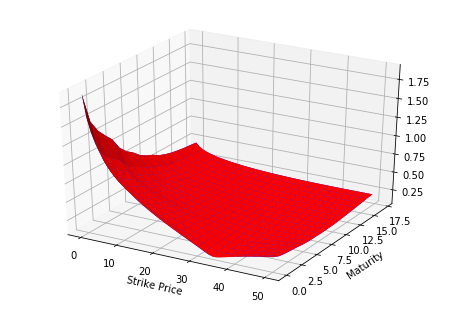

In [20]:
# Using a set of parameters for each maturity
T= np.arange (0, 51, 1) 
K= np.arange (0, 18, 1)

vecimpliedvol=np.vectorize(impliedvolatility_2)
observol=np.vectorize(observed_volatilility)
X, Y = np.meshgrid(T,K)
iv = vecimpliedvol(X,Y)
ov= observol(X,Y)

fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(X,Y, ov,color='blue')
ax.plot_surface(X,Y, iv, color='red')
plt.xlabel('Strike Price')
plt.ylabel('Maturity')
plt.show()

### What happens when the underlying price changes?

In [21]:
#Set of parameters (9th maturity - higher forward price)
f0=fwd[1]
atm=strike/f0

#alpha=alpha_c[8]
#sigma0=sigma0_c[8]
#rho=rho_c[8]
ff=fwd*1.5
beta=1
t1 = time()

s=(len(strike),len(Tex))
IV_hagan2 = np.zeros(s)
for j in range(0,len(Tex)):
    for i in range(0,len(strike)):
        IV_hagan2[i][j] = hagan(strike[i],ff[j],Tex[j],alpha_c[j],beta,rho_c[j],sigma0_c[j])

print('Time to get vol. surface: {} seconds'.format(round((time() - t1), 5)))

Time to get vol. surface: 0.02998 seconds


In [22]:
#Set of parameters (9th maturity - lower forward price)

#alpha=alpha_c[8]
#sigma0=sigma0_c[8]
#rho=rho_c[8]
fff=fwd*0.5
beta=1
t1 = time()

s=(len(strike),len(Tex))
IV_hagan3 = np.zeros(s)
for j in range(0,len(Tex)):
    for i in range(0,len(strike)):
        IV_hagan3[i][j] = hagan(strike[i],fff[j],Tex[j],alpha_c[j],beta,rho_c[j],sigma0_c[j])

print('Time to get vol. surface: {} seconds'.format(round((time() - t1), 5)))

Time to get vol. surface: 0.02898 seconds


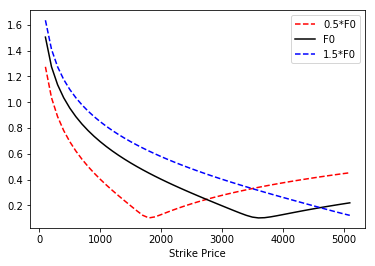

In [23]:
# Using a single set of parameters
## Drawing Smile for a single maturity
plt.plot(strike,IV_hagan3[:,1],'g--',color='red',label='0.5*F0')
plt.plot(strike,IV_hagan[:,1],color= 'black',label='F0')
plt.plot(strike,IV_hagan2[:,1],'g--',color='blue',label='1.5*F0')
plt.xlabel('Strike Price')
plt.show
plt.legend()
plt.savefig('smile_f')
# As expected the Hagan formula replicates 

### Goodness of fit : Mean Squared Errors (MSE)

In [27]:
# Using different parameters for each maturity
sq_error=np.zeros(s)
for j in range(0,len(Tex)):
    for i in range(0,len(strike)):
        sq_error[i][j] = (sigma_iv[i][j]-IV_hagan[i][j])**2
sse1=sum(sq_error)
sse_hagan=sum(sse1)
M=len(strike)*len(Tex)
mse_hagan=sse_hagan/M

mse_T=np.zeros(len(Tex))
for i in range(0,len(Tex)):
    mse_T[i]=sum(sq_error[:,i])/len(strike)

mse_K=np.zeros(len(strike))
for i in range(0,len(strike)):
    mse_K[i]=sum(sq_error[i,:])/len(Tex)

In [28]:
# Using a single set of parameters for all maturities
sq_error=np.zeros(s)
for j in range(0,len(Tex)):
    for i in range(0,len(strike)):
        sq_error[i][j] = (sigma_iv[i][j]-IV_hagan1[i][j])**2
sse2=sum(sq_error)
sse2_hagan=sum(sse2)
M=len(strike)*len(Tex)
mse2_hagan=sse2_hagan/M

mse2_T=np.zeros(len(Tex))
for i in range(0,len(Tex)):
    mse2_T[i]=sum(sq_error[:,i])/len(strike)

mse2_K=np.zeros(len(strike))
for i in range(0,len(strike)):
    mse2_K[i]=sum(sq_error[i,:])/len(Tex)

In [29]:
print(mse_hagan,mse2_hagan)

5.484566252859865e-07 0.017494181952820244


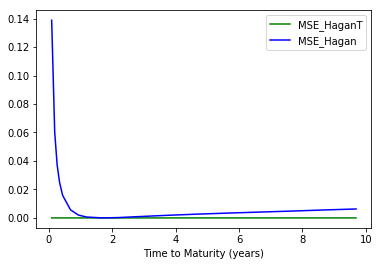

In [30]:
plt.plot(Tex,mse_T,label="MSE_HaganT", color='green')
plt.plot(Tex,mse2_T,label="MSE_Hagan", color ='blue')
plt.xlabel("Time to Maturity (years)")
plt.show
plt.legend()
plt.savefig('mse_T_hagan')

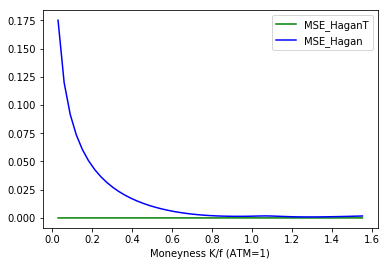

In [31]:
f0=fwd[8]
atm=strike/f0

plt.plot(atm,mse_K,label="MSE_HaganT", color='green')
plt.plot(atm,mse2_K,label="MSE_Hagan", color='blue')
plt.xlabel("Moneyness K/f (ATM=1)")
plt.show
plt.legend()
plt.savefig('mse_K_hagan')

# 3. Willard's Formula in the SABR Model and Conditional Monte Carlo

## SABR Model

The SABR Model is a stochastic volatility model whose time evolution is given by the following system of stochastic differential equations:
$$dF_t=F_t\sigma_t dW_t^{(1)}$$
$$d\sigma_t=\sigma_t \alpha dW_t^{(2)}$$

Where, $W_t^{(1)}$ and $W_t^{(2)}$ are two (02) correlated standard brownian motion, such that $Corr\big(W_t^{(1)},W_t^{(2)}\big)=\rho $

We know that: 
* $\big\{ W_{t_i}^{(2)} \big\}_0^T$ is a stochastic process, such that $W_{t_{i}}^{(2)} = W_{t_{i-1}}^{(2)} + \mathcal{N}(0,t_{i}-t_{i-1})$, $\forall t_i \in [0,T]$ 
* $\big\{ \sigma_{t_i} \big\}_0^T$ is a stochastic process, such that $\sigma_{t_{i}} =\sigma_0 e^{ -0.5 \alpha^2t_i+\alpha W_{t_{i}}^{(2)} }$, $\forall t_i \in [0,T]$
* Call Option Price:= $V_0=E\Big[ e^{-rT}(F_T-K)_+ \ \big| \ \mathcal{F_0}   \Big]$ 

Lets assume $\rho\not= 0$, then it is useful to re-write $W_t^{(1)}$ as:
$$W_t^{(1)}= \sqrt{1-\rho^2}Z_t+\rho W_t^{(2)}$$
where $W_t^{(2)}$ and $Z_t$ are independent standard brownian motion. In consequence, the SABR Model can be re-write as:
$$dF_t=F_t\sigma_t (\sqrt{1-\rho^2}dZ_t+\rho dW_t^{(2)})$$
$$d\sigma_t=\sigma_t \alpha dW_t^{(2)}$$

## Willard's Formula

Lets price a Call Option:

$V_0=E\Big[ e^{-rT}(F_T-K)_+ \  \Big]$

Using the Law of Iterated Expectations, we can re-write $V_0$ as:

$V_0=E\Big[ E\Big[ e^{-rT}(F_T-K)_+ \ \big| \ \big\{ W_{t_i}^{(2)} \big\}_0^T, \big\{ \sigma_{t_i} \big\}_0^T   \Big] \   \Big]$

$V_0=E\Big[ e^{-rT} E\Big[ \big(F_0 e^{-\frac{1}{2} \int_{0}^{T}{\sigma_s^2ds}+\sqrt{1-\rho^2}\int_{0}^{T}{\sigma_sdZ_s}+\rho \int_{0}^{T}{\sigma_sdW_s^{(2)}}} -K \big)_+  \ \big| \ \big\{ W_{t_i}^{(2)} \big\}_0^T, \big\{ \sigma_{t_i} \big\}_0^T \  \Big] \  \Big]$

Lets assume we know $\bar{\sigma_{\rho}}^2:=\frac{1}{T}\Big(\int_{0}^{T}{\sigma_s^2ds}-\rho^2\int_{0}^{T}{\sigma_s^2ds}\Big)$, then we can re-write $V_0$ as:

$V_0=E\Big[ e^{-rT} E\Big[ \big(F_0 e^{-\frac{1}{2} \big(\bar{\sigma_{\rho}}^2T+\rho^2\int_{0}^{T}{\sigma_s^2ds}\big)+\sqrt{1-\rho^2}\int_{0}^{T}{\sigma_sdZ_s}+\rho \int_{0}^{T}{\sigma_sdW_s^{(2)}}} -K \big)_+  \ \big| \ \big\{ W_{t_i}^{(2)} \big\}_0^T \  \Big] \  \Big]$

Lets assume we know $ln(\xi_0):= \rho \int_{0}^{T}{\sigma_sdW_s^{(2)}}-\frac{1}{2}\rho^2\int_{0}^{T}{\sigma_s^2ds}$, then we can re-write $V_0$ as:

$V_0=E\Big[ e^{-rT} E\Big[ \big(F_0\xi_0 e^{-\frac{1}{2}\bar{\sigma_{\rho}}^2T+\sqrt{1-\rho^2}\int_{0}^{T}{\sigma_sdZ_s}} -K \big)_+  \  \Big] \  \Big]$

Note that, $\sqrt{1-\rho^2}\int_{0}^{T}{\sigma_sdZ_s}=\mathcal{N}(0,\bar{\sigma_{\rho}}^2T)$. 

Then we can re-write $V_0$ as:

$V_0=E\Big[ e^{-rT} E\Big[ \big(F_0\xi_0 e^{-\frac{1}{2}\bar{\sigma_{\rho}}^2T+\bar{\sigma_{\rho}}\sqrt{T}\mathcal{N}(0,1)} -K \big)_+  \  \Big] \   \Big]$

Recall that, $\big(F_0\xi_0 e^{-\frac{1}{2}\bar{\sigma_{\rho}}^2T+\bar{\sigma_{\rho}}\sqrt{T}\mathcal{N}(0,1)} -K \big)_+ \not= 0 \iff  F_0\xi_0 e^{-\frac{1}{2}\bar{\sigma_{\rho}}^2T+\bar{\sigma_{\rho}}\sqrt{T}\mathcal{N}(0,1)} > K$. 

Then $\mathcal{N}(0,1) < d_2:= \frac{ln\big(\frac{F_0\xi_0}{K}\big)-\frac{1}{2}\bar{\sigma_{\rho}}^2T}{\bar{\sigma_{\rho}}\sqrt{T}}$, then we can re-write $V_0$ as:

$V_0=E\Big[ e^{-rT} \big( \int_{-\infty}^{d_2} F_0\xi_0 \frac{e^{-\frac{(x-\bar{\sigma_{\rho}}\sqrt{T})^2}{2}}}{\sqrt{2\pi}}dx -K \Pr(x<d_2) \big)  \  \Big] = E\Big[ e^{-rT} \big( F_0\xi_0\Pr(x-\bar{\sigma_{\rho}}\sqrt{T}<d_2) -K \Pr(x<d_2) \big)  \  \Big] $


$V_0=E\Big[ e^{-rT} \big( F_0\xi_0\Pr(x<d_2+\bar{\sigma_{\rho}}\sqrt{T}) -K \Pr(x<d_2) \big)  \  \Big] = E\Big[ e^{-rT} \big( F_0\xi_0\Pr(x<d_1) -K \Pr(x<d_2) \big)  \  \Big] $

In consequence, the option price is equivalent to the following expectation:

$V_0= E\Big[ BS(F_0\xi_0, K, \bar{\sigma_{\rho}}, T, r)) \  \Big] $

Where, $BS(F_0\xi_0, K, \bar{\sigma_{\rho}}, T, r)$ is the Black Scholes formula

Then, the price of a call option with stochastic volatility can be obtained after solving this expectation using a simple Monte Carlo. The main advantage of this procedure is that we reduce the dimension of uncertainty, because we only compute $W_t^{(2)}$. This procedure is known as Conditional Monte Carlo.


In [32]:
# Setting up the Conditional Monte Carlo Simulation

def BlackScholes(F0, K, sigma, T, r):
    d1 = (np.log(F0 / K) + sigma**2 / 2 * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    BSprice = np.exp(-r * T) * (F0 *  ss.norm.cdf(d1) - K * ss.norm.cdf(d2))
    return(BSprice)

def Vega(F0, K, sigma, T):
    d1 = (np.log(F0 / K) + sigma**2 / 2 * T) / (sigma * np.sqrt(T))      
    vega = np.exp(-r * T) * F0*ss.norm.pdf(d1)*np.sqrt(T)
    return(vega) 

def mcOptionPrice(Z, alpha, sigma_0, rho, T, n, F0, K, r,m):
    OptionPrice = 0
    for i in range(0,m):
        Z1 = Z[i,]
        t = np.arange(0,T+T/n,T/n)
        Z2 = Z1*np.sqrt(T/n)
        W2 = np.zeros(n+1)
        W2[1:n+1] = np.cumsum(Z2)
        sigma = sigma_0*np.exp(-0.5 * alpha**2 * t[0:n+1] + alpha * W2) # stochastic volatility compute from the GBM from 0 to T
        # integral approximation as finite sums
        deterministic_integral = np.sum(sigma[0:-1]**2)* T / n       # 1/n := constant time step, then 1/n = t(i+1)-t(i) for all i
        stochastic_integral    = np.dot(sigma[0:-1],np.diff(W2))   
        ksi_0 = np.exp(rho * stochastic_integral - 0.5 * rho**2 * deterministic_integral)    
        sigma_rho = np.sqrt(1/T * (1-rho**2) * deterministic_integral)
        OptionPrice += BlackScholes(F0 * ksi_0, K, sigma_rho, T, r)/m    
    return(OptionPrice)


def nrImplied_Volatility3(mcOptionPrice,F0,T,K,r):
    
    def f(I0):
        f=(BlackScholes(F0,K,I0,T,r)-mcOptionPrice)**2
        return(f) 
    
    #I =optimize.brent(f,brack=(0.001,3))
    I = optimize.fminbound(f, 0.005, 5)
    return(I)

when the option price obtained using Conditional Monte Carlo is close to $e^{-rT}(F_0-K)$ the implied volatility obtained analitically using the Black and Scholes Formula is EXTREMELY close to zero. This result can be confused by the program when $F_0$ is big, K is small, T is very small and $\sigma$ is very big, because $C_0\approx e^{-rT}(F_0-K)$ when sigma is extremely big (like 100%) and T is extremely small (like 0.1).

Basically, I have a double root issue here, one that is not detected by the brent method.

To avoid this issue, I need to check if the random process (Z) gives me the same result using a extreme pair (T= 0.1, K= 100), before computing the surface and obtain something weird, like the surface shown in the last cell.

Another possibility is to constrain the IV in the brent method to be between 1 and 5 and only use it when the IV obtained using my NR method return $\inf$ or -$\inf$.

In [ ]:
# CMC SIMULATION USING A SINGLE SET OF PARAMETERS FOR ALL MATURITIES

start = time()

# Parameters
alpha = alpha_c[8]; sigma_0 = sigma0_c[8]; rho = rho_c[8]     #SABR Model parameters
r  = 0.005;                                                   #BlackScholes parameters     
n  = 10000; m  = 10000                                        # Steps and Realizations

# Uncertainty 
Z = np.random.normal(0,1,[m,n])

# Grip of Maturities and Strikes
vecK = strike
vecT = Tex
vecF0= fwd

sizeT = np.size(vecT)                # vecT is a vector with all the maturities we are going to use to compute the surface
sizeK = np.size(vecK)                # vecK is a vector with all the Strikes we are going to use to compute the surface
I1=np.zeros([sizeT,sizeK])            # initialize matriz of zeros for Implied Volatility

# Volatility Surface
print('alpha=',alpha,'sigma_0=',sigma_0,'rho=',rho)
for j in range(0,sizeT):
    for k in range(0,sizeK):
        OptionPrice = mcOptionPrice(Z, alpha, sigma_0, rho, vecT[j], n, vecF0[j], vecK[k], r,m)
        I1[j][k]=nrImplied_Volatility3(OptionPrice,vecF0[j],vecT[j],vecK[k],r)
    print(j)
end = time()

print(np.max(I1),np.min(I1),end - start, ' seconds')

In [78]:
IV_CMC=np.transpose(I1)

In [80]:
df=pd.DataFrame(data=IV_CMC,        # values
                index=vecK,    # 1st column as index
                columns=vecT)  # 1st row as the column names

# SAVE THE SURFACE IN AN EXCEL FILE

df.to_excel("IV_CMC.xlsx")

In [ ]:
# Function which helps 3D plotting
def forPlottingIVMC(i,j):
    return IV_CMC[i][j]

# Function which helps 3D plotting
def forPlottingIV(i,j):
    return sigma_iv[i][j]

# 3D plot of Implied Volatility
T = np.arange(0,sizeT,1)#T = np.arange(vecT[0], vecT[-1]+vecT[-1]/sizeT, vecT[-1]/sizeT) 
S = np.arange(0,sizeK,1)#S = np.arange (vecK[0], vecK[-1]+vecK[-1]/sizeK, vecK[-1]/sizeK)

np.meshgrid(T,S)

vecPriceMC=np.vectorize(forPlottingIVMC)
vecPrice=np.vectorize(forPlottingIV)
X, Y = np.meshgrid(S,T)
muMC = vecPriceMC(X,Y)
mu = vecPrice(X,Y)

# Implied volatility 3D plot for different maturity times and strikes
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(Y,X, mu, color='blue')
ax.plot_surface(Y,X, muMC, color='green')
plt.xlabel('Maturity')
plt.ylabel('Strike')
plt.show()

In [ ]:
# Let's plot the three surfaces together

# Function which helps 3D plotting
def forPlottingIVMC(i,j):
    return IV_CMC[i][j]

def forPlottingIVHagan1(i,j):
    return IV_hagan1[i][j]

def forPlottingIV(i,j):
    return sigma_iv[i][j]

# 3D plot of Implied Volatility
T = np.arange(0,sizeT,1)#T = np.arange(vecT[0], vecT[-1]+vecT[-1]/sizeT, vecT[-1]/sizeT) 
S = np.arange(0,sizeK,1)#S = np.arange (vecK[0], vecK[-1]+vecK[-1]/sizeK, vecK[-1]/sizeK)

np.meshgrid(T,S)

vecPriceMC=np.vectorize(forPlottingIVMC)
vecPriceHagan=np.vectorize(forPlottingIVHagan1)
vecPrice=np.vectorize(forPlottingIV)
X, Y = np.meshgrid(S,T)
muMC = vecPriceMC(X,Y)
muHagan= vecPriceHagan(X,Y)
mu = vecPrice(X,Y)

# Implied volatility 3D plot for different maturity times and strikes
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(Y,X, mu, color='blue')
ax.plot_surface(Y,X, muMC, color='green')
ax.plot_surface(Y,X, muHagan, color='red')
plt.xlabel('Maturity')
plt.ylabel('Strike')
plt.show()

In [33]:
#lOADING VOL SURFACE
file = 'data_IVmc.xlsx'
xl = pd.ExcelFile(file)
df2 = xl.parse('data_IVmc', index_col=None, header=None)
df2=df2.drop(0,axis=0)
df2=df2.drop(0,axis=1)

# CMC Implied volatility array
s = (len(strike),len(Tex))
sigma_CMC = np.zeros(s)
for i in range(1,19):
    for j in range(1,52):
        sigma_CMC[j-1][i-1] = df2[i][j]

sigma_CMC=np.array(sigma_CMC,dtype=np.float64)

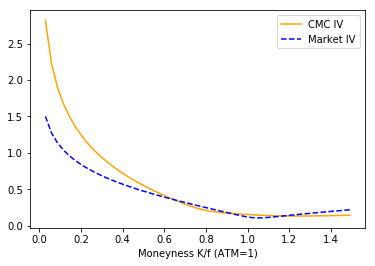

In [35]:
# Using a single set of parameters
## Drawing Smile for a single maturity
f0=fwd[1]
atm=strike/f0

plt.plot(atm,sigma_CMC[:,1],color= 'orange',label='CMC IV')
plt.plot(atm,sigma_iv[:,1],'g--',color='blue',label='Market IV')
plt.xlabel('Moneyness K/f (ATM=1)')
plt.show
plt.legend()
plt.savefig('smile_CMC1')

In [ ]:
# Using a single set of parameters
## Drawing Smile for a single maturity
f0=fwd[1]
atm=strike/f0

plt.plot(atm,IV_CMC[:,1],color= 'red',label='CMC IV')
plt.plot(atm,sigma_iv[:,1],'g--',color='blue',label='Market IV')
plt.xlabel('Moneyness K/f (ATM=1)')
plt.show
plt.legend()
plt.savefig('smile_CMC')

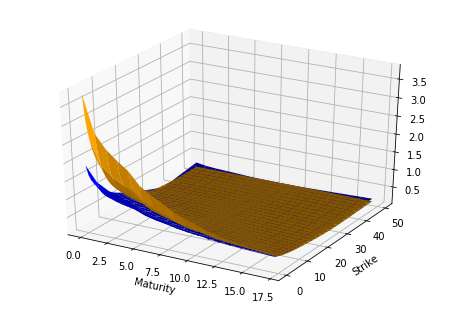

In [57]:
# Function which helps 3D plotting
def forPlottingIVMCa(i,j):
    return sigma_CMC[i][j]

# Function which helps 3D plotting
def forPlottingIV(i,j):
    return sigma_iv[i][j]

vecK = strike
vecT = Tex
vecF0= fwd

sizeT = np.size(vecT)                
sizeK = np.size(vecK)

# 3D plot of Implied Volatility
T = np.arange(0,sizeT,1)#T = np.arange(vecT[0], vecT[-1]+vecT[-1]/sizeT, vecT[-1]/sizeT) 
S = np.arange(0,sizeK,1)#S = np.arange (vecK[0], vecK[-1]+vecK[-1]/sizeK, vecK[-1]/sizeK)

np.meshgrid(T,S)

vecPriceMC=np.vectorize(forPlottingIVMCa)
vecPrice=np.vectorize(forPlottingIV)
X, Y = np.meshgrid(S,T)
muMC = vecPriceMC(X,Y)
mu = vecPrice(X,Y)

# Implied volatility 3D plot for different maturity times and strikes
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(Y,X, mu, color='blue')
ax.plot_surface(Y,X, muMC, color='orange')
plt.xlabel('Maturity')
plt.ylabel('Strike')
plt.show()

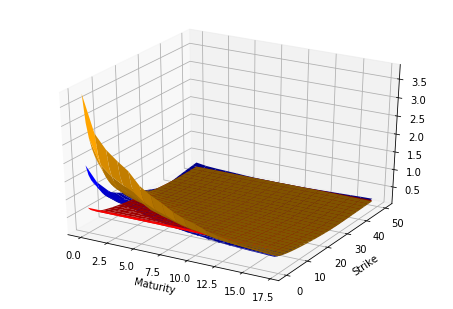

In [58]:
# Function which helps 3D plotting
def forPlottingIVMCa(i,j):
    return sigma_CMC[i][j]

def forPlottingIVHagan1(i,j):
    return IV_hagan1[i][j]

# Function which helps 3D plotting
def forPlottingIV(i,j):
    return sigma_iv[i][j]

# 3D plot of Implied Volatility
T = np.arange(0,sizeT,1)#T = np.arange(vecT[0], vecT[-1]+vecT[-1]/sizeT, vecT[-1]/sizeT) 
S = np.arange(0,sizeK,1)#S = np.arange (vecK[0], vecK[-1]+vecK[-1]/sizeK, vecK[-1]/sizeK)

np.meshgrid(T,S)

vecPrice=np.vectorize(forPlottingIV)
vecPriceMC=np.vectorize(forPlottingIVMCa)
vecPriceHagan=np.vectorize(forPlottingIVHagan1)
X, Y = np.meshgrid(S,T)
muMC = vecPriceMC(X,Y)
mu = vecPrice(X,Y)
muHagan= vecPriceHagan(X,Y)

# Implied volatility 3D plot for different maturity times and strikes
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(Y,X, mu, color='blue')
ax.plot_surface(Y,X, muMC, color='orange')
ax.plot_surface(Y,X, muHagan, color='red')
plt.xlabel('Maturity')
plt.ylabel('Strike')
plt.show()

#### CALCULATING MEAN SQUARE ERRORS FOR THE CMC SURFACE WRT TO THE MARKET SURFACE

In [42]:
sq_error=np.zeros(s)
for j in range(0,len(Tex)):
    for i in range(0,len(strike)):
        sq_error[i][j] = (sigma_iv[i][j]-sigma_CMC[i][j])**2
sse3=sum(sq_error)
sse3_CMC=sum(sse3)
M=len(strike)*len(Tex)
mse3_CMC=sse3_CMC/M

# MSE by Maturity
mse3_T=np.zeros(len(Tex))
for i in range(0,len(Tex)):
    mse3_T[i]=sum(sq_error[:,i])/len(strike)
# MSE by Strike
mse3_K=np.zeros(len(strike))
for i in range(0,len(strike)):
    mse3_K[i]=sum(sq_error[i,:])/len(Tex)

In [43]:
mse3_CMC

0.029264102701985664

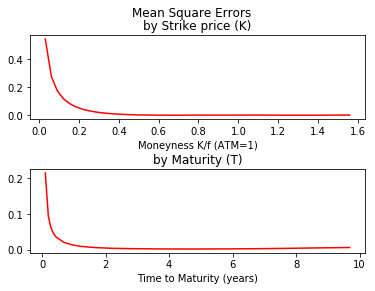

In [107]:
# Only CMC errors
plt.subplot(2,1,1)    
plt.plot(atm,mse3_K,label="MSE_CMC",color='red')
plt.title('by Strike price (K)')
plt.xlabel("Moneyness K/f (ATM=1)")

plt.subplot(2,1,2)    
plt.plot(Tex,mse3_T,label="MSE_CMC", color='red')
plt.xlabel("Time to Maturity (years)")
plt.title('by Maturity (T)')

plt.suptitle('Mean Square Errors')
plt.subplots_adjust(hspace=0.6)#,left=0, bottom=0, right=1, top=1, wspace=0.1, )

plt.show()

# 4. Comparing Hagan and CMC

In [48]:
#!pip install tabulate

In [56]:
# COMPUTING TIME
from IPython.display import HTML, display
import tabulate
table = [["Method",'Est. Time (seconds)'],
         ["Hagan (by T)",round(0.07812,2)],
         ["Hagan",round(0.07811,2)],
         ["CMC",round(8908.333573818207,2)]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

Method,Est. Time (seconds)
Hagan (by T),0.08
Hagan,0.08
CMC,8908.33


In [50]:
# MEAN SQUARED ERRORS FOR THE ENTIRE SURFACE
from IPython.display import HTML, display
import tabulate
table = [["Method",'MSE (%)'],
         ["Hagan (by T)",round(mse_hagan*100,3)],
         ["Hagan",round(mse2_hagan*100,3)],
         ["CMC",round(mse3_CMC*100,3)],]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

Method,MSE (%)
Hagan (by T),0.0
Hagan,1.743
CMC,2.926


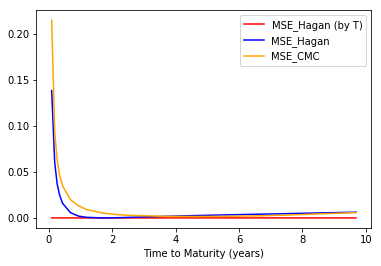

In [59]:
# MEAN SQUARE ERRORS BY MATURITY
f0=fwd[8]
atm=strike/f0

plt.plot(Tex,mse_T,label="MSE_Hagan (by T)", color='red')
plt.plot(Tex,mse2_T,label="MSE_Hagan", color='blue')
plt.plot(Tex,mse3_T,label="MSE_CMC", color='orange')
plt.xlabel("Time to Maturity (years)")
plt.show
plt.legend()
plt.savefig('mse_T_hagan-CMC1')

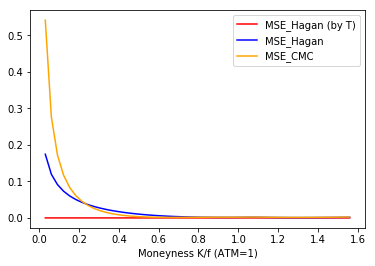

In [60]:
# MEAN SQUARE ERRORS BY STRIKE PRICE
plt.plot(atm,mse_K,label="MSE_Hagan (by T)",color='red')
plt.plot(atm,mse2_K,label="MSE_Hagan",color='blue')
plt.plot(atm,mse3_K,label="MSE_CMC",color='orange')
plt.xlabel("Moneyness K/f (ATM=1)")
plt.show
plt.legend()
plt.savefig('mse_K_hagan-CMC1')